# Main Diffusion Script
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
    from audio_encoders_pytorch import MelE1d, TanhBottleneck
except:
    !pip install audio-diffusion-pytorch
    !pip install audio-encoders-pytorch
try: 
    import a_unet
except:
    !pip install a_unet

#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, DiffusionAE, VDiffusion, VSampler, UNetV0, LTPlugin
from audio_encoders_pytorch import MelE1d, TanhBottleneck, ME1d

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

General

In [2]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_autoencoder_v10"
training_data_name: str = "training_full_wave"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [3]:
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [4]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 2500
n_validation_samples: int = 50
batch_size: int = 16
tensor_dim: list = [batch_size, 1, 65636 * 2] #B, C, H = Batch, channels, Time domain

learning_rate: float = 1e-4
epochs: int = 300
restart_training: bool = True
checkpoint_freq: int = 5

### Data Loading

In [5]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:, :2**17]
np.random.seed(50)
np.random.shuffle(file)
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-04 06:41:18,944 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_wave.npy of shape: (5906, 147200)
2025-06-04 06:41:19,946 - INFO - Data loaded with shape: (5906, 131072)


### Setup

Model Creation

In [ ]:
autoencoder = DiffusionAE(
    encoder=ME1d( 
        in_channels=1,
        use_log=True,
        stft_num_fft=1023,
        stft_hop_length=8,
        channels=128,
        multipliers=[1, 1],
        factors=[2],
        num_blocks=[12],
        bottleneck=TanhBottleneck(),
        out_channels=256,
    ),
    inject_depth=4,
    net_t=UNetV0,
    in_channels=1,
    channels=[32, 64, 64, 128, 128, 256, 256], 
    factors=[1, 2, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2, 2],
    diffusion_t=VDiffusion,
    sampler_t=VSampler, 
).to(device)


Model Loading

In [7]:
optimizer = optim.AdamW(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-3, betas=[0.95, 0.999], eps=1e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    autoencoder.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(autoencoder)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(autoencoder)} Parameters")

2025-06-04 06:41:25,450 - INFO - Model diffusion_autoencoder_v10 loaded with ~16.10M Parameters


Initiate Trainer

In [8]:
trainer = Trainer(autoencoder, optimizer, scheduler, device, n_dims=1)

### Training

2025-06-03 18:40:41,825 - INFO - Training started on cuda


2025-06-03 18:43:01,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.106 Min/Max params: -2.424, 2.806


2025-06-03 18:43:03,050 - INFO - Epoch 001: Avg. Loss: 1.97604e-01 Avg. val. Loss: 1.30283e-01 Remaining Time: 11h 43min 44s LR: 9.80000e-05 


2025-06-03 18:45:26,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.394 Min/Max params: -2.423, 2.805


2025-06-03 18:45:27,878 - INFO - Epoch 002: Avg. Loss: 1.23895e-01 Avg. val. Loss: 9.58574e-02 Remaining Time: 11h 50min 20s LR: 9.60400e-05 


2025-06-03 18:47:48,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.064 Min/Max params: -2.422, 2.805


2025-06-03 18:47:50,246 - INFO - Epoch 003: Avg. Loss: 1.19410e-01 Avg. val. Loss: 8.77099e-02 Remaining Time: 11h 46min 52s LR: 9.41192e-05 


2025-06-03 18:50:13,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.056 Min/Max params: -2.421, 2.803


2025-06-03 18:50:15,007 - INFO - Epoch 004: Avg. Loss: 1.25156e-01 Avg. val. Loss: 9.61044e-02 Remaining Time: 11h 46min 54s LR: 9.22368e-05 


2025-06-03 18:52:35,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.112 Min/Max params: -2.421, 2.803


2025-06-03 18:52:37,013 - INFO - Epoch 005: Avg. Loss: 1.25080e-01 Avg. val. Loss: 1.11967e-01 Remaining Time: 11h 43min 15s LR: 9.03921e-05 
2025-06-03 18:52:37,287 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_005.pth


2025-06-03 18:54:58,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.065 Min/Max params: -2.422, 2.804


2025-06-03 18:54:59,343 - INFO - Epoch 006: Avg. Loss: 1.24935e-01 Avg. val. Loss: 2.15538e-01 Remaining Time: 11h 40min 04s LR: 8.85842e-05 


2025-06-03 18:57:23,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.073 Min/Max params: -2.424, 2.807


2025-06-03 18:57:24,646 - INFO - Epoch 007: Avg. Loss: 1.26312e-01 Avg. val. Loss: 1.26821e-01 Remaining Time: 11h 39min 23s LR: 8.68126e-05 


2025-06-03 18:59:43,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.103 Min/Max params: -2.427, 2.810


2025-06-03 18:59:45,199 - INFO - Epoch 008: Avg. Loss: 1.34014e-01 Avg. val. Loss: 1.21257e-01 Remaining Time: 11h 35min 22s LR: 8.50763e-05 


2025-06-03 19:02:08,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.244 Min/Max params: -2.424, 2.808


2025-06-03 19:02:09,384 - INFO - Epoch 009: Avg. Loss: 1.49571e-01 Avg. val. Loss: 1.18277e-01 Remaining Time: 11h 33min 41s LR: 8.33748e-05 


2025-06-03 19:04:31,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.141 Min/Max params: -2.424, 2.809


2025-06-03 19:04:33,054 - INFO - Epoch 010: Avg. Loss: 1.39664e-01 Avg. val. Loss: 1.50048e-01 Remaining Time: 11h 31min 37s LR: 8.17073e-05 
2025-06-03 19:04:33,348 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_005.pth deleted
2025-06-03 19:04:33,349 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_010.pth


2025-06-03 19:06:55,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.084 Min/Max params: -2.424, 2.809


2025-06-03 19:06:56,926 - INFO - Epoch 011: Avg. Loss: 1.34078e-01 Avg. val. Loss: 1.21003e-01 Remaining Time: 11h 29min 26s LR: 8.00731e-05 


2025-06-03 19:09:19,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.094 Min/Max params: -2.425, 2.809


2025-06-03 19:09:20,213 - INFO - Epoch 012: Avg. Loss: 1.34470e-01 Avg. val. Loss: 1.38854e-01 Remaining Time: 11h 27min 06s LR: 7.84717e-05 


2025-06-03 19:11:43,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.133 Min/Max params: -2.424, 2.809


2025-06-03 19:11:44,667 - INFO - Epoch 013: Avg. Loss: 1.33166e-01 Avg. val. Loss: 1.33064e-01 Remaining Time: 11h 25min 12s LR: 7.69022e-05 


2025-06-03 19:14:08,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.119 Min/Max params: -2.426, 2.811


2025-06-03 19:14:09,840 - INFO - Epoch 014: Avg. Loss: 1.35123e-01 Avg. val. Loss: 1.68136e-01 Remaining Time: 11h 23min 28s LR: 7.53642e-05 


2025-06-03 19:16:29,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.142 Min/Max params: -2.427, 2.812


2025-06-03 19:16:30,849 - INFO - Epoch 015: Avg. Loss: 1.39290e-01 Avg. val. Loss: 1.11689e-01 Remaining Time: 11h 20min 19s LR: 7.38569e-05 
2025-06-03 19:16:31,276 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_010.pth deleted
2025-06-03 19:16:31,277 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_015.pth


2025-06-03 19:18:53,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.095 Min/Max params: -2.428, 2.812


2025-06-03 19:18:55,138 - INFO - Epoch 016: Avg. Loss: 1.28560e-01 Avg. val. Loss: 1.05822e-01 Remaining Time: 11h 18min 07s LR: 7.23798e-05 


2025-06-03 19:21:14,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.128 Min/Max params: -2.427, 2.811


2025-06-03 19:21:15,809 - INFO - Epoch 017: Avg. Loss: 1.47642e-01 Avg. val. Loss: 1.45102e-01 Remaining Time: 11h 15min 01s LR: 7.09322e-05 


2025-06-03 19:23:37,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.243 Min/Max params: -2.427, 2.811


2025-06-03 19:23:39,148 - INFO - Epoch 018: Avg. Loss: 1.30285e-01 Avg. val. Loss: 1.67507e-01 Remaining Time: 11h 12min 41s LR: 6.95135e-05 


2025-06-03 19:26:04,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.098 Min/Max params: -2.427, 2.811


2025-06-03 19:26:06,723 - INFO - Epoch 019: Avg. Loss: 1.31148e-01 Avg. val. Loss: 1.28291e-01 Remaining Time: 11h 11min 24s LR: 6.81233e-05 


2025-06-03 19:28:31,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.208 Min/Max params: -2.427, 2.811


2025-06-03 19:28:33,264 - INFO - Epoch 020: Avg. Loss: 1.31773e-01 Avg. val. Loss: 1.38520e-01 Remaining Time: 11h 09min 45s LR: 6.67608e-05 
2025-06-03 19:28:33,746 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_015.pth deleted
2025-06-03 19:28:33,747 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_020.pth


2025-06-03 19:30:54,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.387 Min/Max params: -2.429, 2.812


2025-06-03 19:30:56,004 - INFO - Epoch 021: Avg. Loss: 1.78958e-01 Avg. val. Loss: 1.88850e-01 Remaining Time: 11h 07min 05s LR: 6.54256e-05 


2025-06-03 19:33:19,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.073 Min/Max params: -2.428, 2.812


2025-06-03 19:33:21,501 - INFO - Epoch 022: Avg. Loss: 1.41661e-01 Avg. val. Loss: 1.22971e-01 Remaining Time: 11h 05min 07s LR: 6.41171e-05 


2025-06-03 19:35:45,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.054 Min/Max params: -2.427, 2.811


2025-06-03 19:35:47,553 - INFO - Epoch 023: Avg. Loss: 1.31480e-01 Avg. val. Loss: 1.32128e-01 Remaining Time: 11h 03min 13s LR: 6.28347e-05 


2025-06-03 19:38:11,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.083 Min/Max params: -2.426, 2.809


2025-06-03 19:38:12,432 - INFO - Epoch 024: Avg. Loss: 1.43414e-01 Avg. val. Loss: 1.06254e-01 Remaining Time: 11h 01min 04s LR: 6.15780e-05 


2025-06-03 19:40:32,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.074 Min/Max params: -2.424, 2.807


2025-06-03 19:40:33,326 - INFO - Epoch 025: Avg. Loss: 1.28756e-01 Avg. val. Loss: 2.21887e-01 Remaining Time: 10h 58min 09s LR: 6.03465e-05 
2025-06-03 19:40:33,617 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_020.pth deleted
2025-06-03 19:40:33,618 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_025.pth


2025-06-03 19:42:54,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.310 Min/Max params: -2.430, 2.8128


2025-06-03 19:42:55,314 - INFO - Epoch 026: Avg. Loss: 6.34824e-01 Avg. val. Loss: 4.02205e-01 Remaining Time: 10h 55min 25s LR: 5.91395e-05 


2025-06-03 19:45:16,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.303 Min/Max params: -2.430, 2.813


2025-06-03 19:45:17,823 - INFO - Epoch 027: Avg. Loss: 2.22196e-01 Avg. val. Loss: 1.43489e-01 Remaining Time: 10h 52min 52s LR: 5.79568e-05 


2025-06-03 19:47:39,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.068 Min/Max params: -2.430, 2.813


2025-06-03 19:47:40,908 - INFO - Epoch 028: Avg. Loss: 1.37127e-01 Avg. val. Loss: 1.32188e-01 Remaining Time: 10h 50min 24s LR: 5.67976e-05 


2025-06-03 19:50:03,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.069 Min/Max params: -2.430, 2.813


2025-06-03 19:50:05,502 - INFO - Epoch 029: Avg. Loss: 1.27747e-01 Avg. val. Loss: 1.18804e-01 Remaining Time: 10h 48min 11s LR: 5.56617e-05 


2025-06-03 19:52:24,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.174 Min/Max params: -2.430, 2.813


2025-06-03 19:52:25,527 - INFO - Epoch 030: Avg. Loss: 1.29955e-01 Avg. val. Loss: 1.39447e-01 Remaining Time: 10h 45min 16s LR: 5.45484e-05 
2025-06-03 19:52:25,816 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_025.pth deleted
2025-06-03 19:52:25,817 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_030.pth


2025-06-03 19:54:49,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.136 Min/Max params: -2.430, 2.813


2025-06-03 19:54:50,641 - INFO - Epoch 031: Avg. Loss: 1.28316e-01 Avg. val. Loss: 8.81333e-02 Remaining Time: 10h 43min 05s LR: 5.34575e-05 


2025-06-03 19:57:13,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.122 Min/Max params: -2.430, 2.813


2025-06-03 19:57:15,062 - INFO - Epoch 032: Avg. Loss: 1.25574e-01 Avg. val. Loss: 1.15289e-01 Remaining Time: 10h 40min 50s LR: 5.23883e-05 


2025-06-03 19:59:37,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.081 Min/Max params: -2.430, 2.813


2025-06-03 19:59:38,553 - INFO - Epoch 033: Avg. Loss: 1.24045e-01 Avg. val. Loss: 1.20144e-01 Remaining Time: 10h 38min 27s LR: 5.13405e-05 


2025-06-03 20:02:01,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.221 Min/Max params: -2.430, 2.813


2025-06-03 20:02:03,034 - INFO - Epoch 034: Avg. Loss: 1.29677e-01 Avg. val. Loss: 1.11094e-01 Remaining Time: 10h 36min 11s LR: 5.03137e-05 


2025-06-03 20:04:28,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.116 Min/Max params: -2.430, 2.812


2025-06-03 20:04:29,510 - INFO - Epoch 035: Avg. Loss: 1.27974e-01 Avg. val. Loss: 1.10206e-01 Remaining Time: 10h 34min 10s LR: 4.93075e-05 
2025-06-03 20:04:29,944 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_030.pth deleted
2025-06-03 20:04:29,945 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_035.pth


2025-06-03 20:06:52,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.072 Min/Max params: -2.430, 2.812


2025-06-03 20:06:53,932 - INFO - Epoch 036: Avg. Loss: 1.28967e-01 Avg. val. Loss: 1.31783e-01 Remaining Time: 10h 31min 49s LR: 4.83213e-05 


2025-06-03 20:09:14,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.110 Min/Max params: -2.430, 2.812


2025-06-03 20:09:15,284 - INFO - Epoch 037: Avg. Loss: 1.25813e-01 Avg. val. Loss: 1.19235e-01 Remaining Time: 10h 29min 10s LR: 4.73549e-05 


2025-06-03 20:11:37,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.324 Min/Max params: -2.429, 2.812


2025-06-03 20:11:38,578 - INFO - Epoch 038: Avg. Loss: 1.28689e-01 Avg. val. Loss: 1.22273e-01 Remaining Time: 10h 26min 45s LR: 4.64078e-05 


2025-06-03 20:13:58,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.060 Min/Max params: -2.429, 2.812


2025-06-03 20:13:59,755 - INFO - Epoch 039: Avg. Loss: 1.27965e-01 Avg. val. Loss: 1.30583e-01 Remaining Time: 10h 24min 05s LR: 4.54796e-05 


2025-06-03 20:16:21,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.118 Min/Max params: -2.429, 2.812


2025-06-03 20:16:22,644 - INFO - Epoch 040: Avg. Loss: 1.25664e-01 Avg. val. Loss: 1.44463e-01 Remaining Time: 10h 21min 38s LR: 4.45700e-05 
2025-06-03 20:16:22,930 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_035.pth deleted
2025-06-03 20:16:22,931 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_040.pth


2025-06-03 20:18:42,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.084 Min/Max params: -2.429, 2.811


2025-06-03 20:18:43,612 - INFO - Epoch 041: Avg. Loss: 1.31030e-01 Avg. val. Loss: 2.60447e-01 Remaining Time: 10h 18min 57s LR: 4.36786e-05 


2025-06-03 20:21:05,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.094 Min/Max params: -2.428, 2.811


2025-06-03 20:21:06,259 - INFO - Epoch 042: Avg. Loss: 1.34669e-01 Avg. val. Loss: 1.35630e-01 Remaining Time: 10h 16min 29s LR: 4.28051e-05 


2025-06-03 20:23:29,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.088 Min/Max params: -2.428, 2.810


2025-06-03 20:23:30,355 - INFO - Epoch 043: Avg. Loss: 1.37803e-01 Avg. val. Loss: 1.16663e-01 Remaining Time: 10h 14min 10s LR: 4.19490e-05 


2025-06-03 20:25:55,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.111 Min/Max params: -2.428, 2.810


2025-06-03 20:25:56,764 - INFO - Epoch 044: Avg. Loss: 1.55098e-01 Avg. val. Loss: 1.23759e-01 Remaining Time: 10h 12min 04s LR: 4.11100e-05 


2025-06-03 20:28:19,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.291 Min/Max params: -2.428, 2.811


2025-06-03 20:28:21,358 - INFO - Epoch 045: Avg. Loss: 1.69939e-01 Avg. val. Loss: 2.00617e-01 Remaining Time: 10h 09min 47s LR: 4.02878e-05 
2025-06-03 20:28:21,637 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_040.pth deleted
2025-06-03 20:28:21,638 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_045.pth


2025-06-03 20:30:43,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.985 Min/Max params: -2.430, 2.812


2025-06-03 20:30:45,145 - INFO - Epoch 046: Avg. Loss: 4.53458e-01 Avg. val. Loss: 2.05903e-01 Remaining Time: 10h 07min 24s LR: 3.94820e-05 


2025-06-03 20:33:08,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.067 Min/Max params: -2.431, 2.813


2025-06-03 20:33:09,843 - INFO - Epoch 047: Avg. Loss: 2.66240e-01 Avg. val. Loss: 3.12246e-01 Remaining Time: 10h 05min 07s LR: 3.86924e-05 


2025-06-03 20:35:31,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.232 Min/Max params: -2.431, 2.813


2025-06-03 20:35:32,427 - INFO - Epoch 048: Avg. Loss: 2.28847e-01 Avg. val. Loss: 2.25289e-01 Remaining Time: 10h 02min 39s LR: 3.79185e-05 


2025-06-03 20:37:56,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.236 Min/Max params: -2.432, 2.814


2025-06-03 20:37:57,732 - INFO - Epoch 049: Avg. Loss: 1.85301e-01 Avg. val. Loss: 1.61603e-01 Remaining Time: 10h 00min 24s LR: 3.71602e-05 


2025-06-03 20:40:19,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.291 Min/Max params: -2.433, 2.815


2025-06-03 20:40:21,092 - INFO - Epoch 050: Avg. Loss: 1.62392e-01 Avg. val. Loss: 1.82482e-01 Remaining Time: 09h 58min 00s LR: 3.64170e-05 
2025-06-03 20:40:21,358 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_045.pth deleted
2025-06-03 20:40:21,359 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_050.pth


2025-06-03 20:42:42,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.151 Min/Max params: -2.434, 2.816


2025-06-03 20:42:43,853 - INFO - Epoch 051: Avg. Loss: 1.63304e-01 Avg. val. Loss: 1.40279e-01 Remaining Time: 09h 55min 31s LR: 3.56886e-05 


2025-06-03 20:45:03,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.086 Min/Max params: -2.434, 2.816


2025-06-03 20:45:05,142 - INFO - Epoch 052: Avg. Loss: 1.52249e-01 Avg. val. Loss: 2.21618e-01 Remaining Time: 09h 52min 57s LR: 3.49749e-05 


2025-06-03 20:47:27,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.112 Min/Max params: -2.435, 2.817


2025-06-03 20:47:28,590 - INFO - Epoch 053: Avg. Loss: 1.57060e-01 Avg. val. Loss: 2.05116e-01 Remaining Time: 09h 50min 34s LR: 3.42754e-05 


2025-06-03 20:49:50,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.236 Min/Max params: -2.435, 2.817


2025-06-03 20:49:51,522 - INFO - Epoch 054: Avg. Loss: 1.56267e-01 Avg. val. Loss: 2.02963e-01 Remaining Time: 09h 48min 08s LR: 3.35899e-05 


2025-06-03 20:52:13,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.053 Min/Max params: -2.435, 2.817


2025-06-03 20:52:15,418 - INFO - Epoch 055: Avg. Loss: 1.59550e-01 Avg. val. Loss: 1.26099e-01 Remaining Time: 09h 45min 46s LR: 3.29181e-05 
2025-06-03 20:52:15,754 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_050.pth deleted
2025-06-03 20:52:15,755 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_055.pth


2025-06-03 20:54:42,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.082 Min/Max params: -2.435, 2.817


2025-06-03 20:54:44,113 - INFO - Epoch 056: Avg. Loss: 1.52511e-01 Avg. val. Loss: 1.25287e-01 Remaining Time: 09h 43min 44s LR: 3.22597e-05 


2025-06-03 20:57:05,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.174 Min/Max params: -2.435, 2.817


2025-06-03 20:57:07,738 - INFO - Epoch 057: Avg. Loss: 1.42514e-01 Avg. val. Loss: 1.35719e-01 Remaining Time: 09h 41min 21s LR: 3.16145e-05 


2025-06-03 20:59:28,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.067 Min/Max params: -2.436, 2.817


2025-06-03 20:59:30,546 - INFO - Epoch 058: Avg. Loss: 1.50395e-01 Avg. val. Loss: 1.92180e-01 Remaining Time: 09h 38min 55s LR: 3.09822e-05 


2025-06-03 21:01:51,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.120 Min/Max params: -2.436, 2.817


2025-06-03 21:01:52,452 - INFO - Epoch 059: Avg. Loss: 1.54133e-01 Avg. val. Loss: 1.70367e-01 Remaining Time: 09h 36min 24s LR: 3.03626e-05 


2025-06-03 21:04:14,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.283 Min/Max params: -2.436, 2.818


2025-06-03 21:04:15,444 - INFO - Epoch 060: Avg. Loss: 1.53388e-01 Avg. val. Loss: 1.81147e-01 Remaining Time: 09h 33min 59s LR: 2.97553e-05 
2025-06-03 21:04:15,709 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_055.pth deleted
2025-06-03 21:04:15,710 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_060.pth


2025-06-03 21:06:36,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.111 Min/Max params: -2.436, 2.818


2025-06-03 21:06:37,945 - INFO - Epoch 061: Avg. Loss: 1.51503e-01 Avg. val. Loss: 1.80611e-01 Remaining Time: 09h 31min 30s LR: 2.91602e-05 


2025-06-03 21:08:59,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.087 Min/Max params: -2.436, 2.818


2025-06-03 21:09:00,761 - INFO - Epoch 062: Avg. Loss: 1.50435e-01 Avg. val. Loss: 1.14303e-01 Remaining Time: 09h 29min 04s LR: 2.85770e-05 


2025-06-03 21:11:20,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.130 Min/Max params: -2.437, 2.819


2025-06-03 21:11:22,365 - INFO - Epoch 063: Avg. Loss: 1.42478e-01 Avg. val. Loss: 1.55639e-01 Remaining Time: 09h 26min 34s LR: 2.80055e-05 


2025-06-03 21:13:44,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.077 Min/Max params: -2.437, 2.819


2025-06-03 21:13:45,995 - INFO - Epoch 064: Avg. Loss: 1.49104e-01 Avg. val. Loss: 1.04673e-01 Remaining Time: 09h 24min 11s LR: 2.74454e-05 


2025-06-03 21:16:08,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.083 Min/Max params: -2.437, 2.819


2025-06-03 21:16:10,057 - INFO - Epoch 065: Avg. Loss: 1.45340e-01 Avg. val. Loss: 1.51606e-01 Remaining Time: 09h 21min 50s LR: 2.68964e-05 
2025-06-03 21:16:10,335 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_060.pth deleted
2025-06-03 21:16:10,336 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_065.pth


2025-06-03 21:18:32,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.100 Min/Max params: -2.437, 2.818


2025-06-03 21:18:33,735 - INFO - Epoch 066: Avg. Loss: 1.52175e-01 Avg. val. Loss: 1.26450e-01 Remaining Time: 09h 19min 26s LR: 2.63585e-05 


2025-06-03 21:20:57,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.070 Min/Max params: -2.436, 2.818


2025-06-03 21:20:58,794 - INFO - Epoch 067: Avg. Loss: 1.38002e-01 Avg. val. Loss: 1.44147e-01 Remaining Time: 09h 17min 08s LR: 2.58313e-05 


2025-06-03 21:23:21,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.261 Min/Max params: -2.436, 2.818


2025-06-03 21:23:23,557 - INFO - Epoch 068: Avg. Loss: 1.44323e-01 Avg. val. Loss: 1.67343e-01 Remaining Time: 09h 14min 49s LR: 2.53147e-05 


2025-06-03 21:25:45,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.105 Min/Max params: -2.437, 2.818


2025-06-03 21:25:46,673 - INFO - Epoch 069: Avg. Loss: 1.42623e-01 Avg. val. Loss: 1.20154e-01 Remaining Time: 09h 12min 25s LR: 2.48084e-05 


2025-06-03 21:28:12,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.134 Min/Max params: -2.437, 2.818


2025-06-03 21:28:13,490 - INFO - Epoch 070: Avg. Loss: 1.43565e-01 Avg. val. Loss: 2.36796e-01 Remaining Time: 09h 10min 12s LR: 2.43123e-05 
2025-06-03 21:28:13,788 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_065.pth deleted
2025-06-03 21:28:13,789 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_070.pth


2025-06-03 21:30:33,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.059 Min/Max params: -2.437, 2.818


2025-06-03 21:30:34,922 - INFO - Epoch 071: Avg. Loss: 1.50171e-01 Avg. val. Loss: 1.06308e-01 Remaining Time: 09h 07min 41s LR: 2.38260e-05 


2025-06-03 21:32:58,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.114 Min/Max params: -2.437, 2.818


2025-06-03 21:33:00,415 - INFO - Epoch 072: Avg. Loss: 1.44480e-01 Avg. val. Loss: 1.12880e-01 Remaining Time: 09h 05min 24s LR: 2.33495e-05 


2025-06-03 21:35:25,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.155 Min/Max params: -2.437, 2.819


2025-06-03 21:35:27,054 - INFO - Epoch 073: Avg. Loss: 1.40290e-01 Avg. val. Loss: 1.32170e-01 Remaining Time: 09h 03min 10s LR: 2.28825e-05 


2025-06-03 21:37:45,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.058 Min/Max params: -2.437, 2.819


2025-06-03 21:37:48,086 - INFO - Epoch 074: Avg. Loss: 1.39961e-01 Avg. val. Loss: 1.30441e-01 Remaining Time: 09h 00min 38s LR: 2.24249e-05 


2025-06-03 21:40:07,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.058 Min/Max params: -2.438, 2.819


2025-06-03 21:40:08,435 - INFO - Epoch 075: Avg. Loss: 1.40312e-01 Avg. val. Loss: 1.19446e-01 Remaining Time: 08h 58min 05s LR: 2.19764e-05 
2025-06-03 21:40:08,846 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_070.pth deleted
2025-06-03 21:40:08,847 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_075.pth


2025-06-03 21:42:29,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.114 Min/Max params: -2.438, 2.819


2025-06-03 21:42:30,894 - INFO - Epoch 076: Avg. Loss: 1.40268e-01 Avg. val. Loss: 2.44517e-01 Remaining Time: 08h 55min 38s LR: 2.15368e-05 


2025-06-03 21:44:52,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.098 Min/Max params: -2.438, 2.819


2025-06-03 21:44:53,313 - INFO - Epoch 077: Avg. Loss: 1.45744e-01 Avg. val. Loss: 1.13869e-01 Remaining Time: 08h 53min 11s LR: 2.11061e-05 


2025-06-03 21:47:15,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.132 Min/Max params: -2.437, 2.819


2025-06-03 21:47:17,593 - INFO - Epoch 078: Avg. Loss: 1.42313e-01 Avg. val. Loss: 1.30390e-01 Remaining Time: 08h 50min 50s LR: 2.06840e-05 


2025-06-03 21:49:41,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.070 Min/Max params: -2.437, 2.819


2025-06-03 21:49:43,159 - INFO - Epoch 079: Avg. Loss: 1.39499e-01 Avg. val. Loss: 1.34481e-01 Remaining Time: 08h 48min 32s LR: 2.02703e-05 


2025-06-03 21:52:04,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.074 Min/Max params: -2.436, 2.818


2025-06-03 21:52:05,555 - INFO - Epoch 080: Avg. Loss: 1.37832e-01 Avg. val. Loss: 1.04637e-01 Remaining Time: 08h 46min 06s LR: 1.98649e-05 
2025-06-03 21:52:05,827 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_075.pth deleted
2025-06-03 21:52:05,828 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_080.pth


2025-06-03 21:54:27,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.077 Min/Max params: -2.436, 2.818


2025-06-03 21:54:28,737 - INFO - Epoch 081: Avg. Loss: 1.40133e-01 Avg. val. Loss: 1.61154e-01 Remaining Time: 08h 43min 41s LR: 1.94676e-05 


2025-06-03 21:56:51,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.118 Min/Max params: -2.436, 2.818


2025-06-03 21:56:53,317 - INFO - Epoch 082: Avg. Loss: 1.39598e-01 Avg. val. Loss: 1.43658e-01 Remaining Time: 08h 41min 20s LR: 1.90782e-05 


2025-06-03 21:59:16,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.255 Min/Max params: -2.436, 2.818


2025-06-03 21:59:18,013 - INFO - Epoch 083: Avg. Loss: 1.44549e-01 Avg. val. Loss: 1.41826e-01 Remaining Time: 08h 39min 00s LR: 1.86967e-05 


2025-06-03 22:01:38,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.118 Min/Max params: -2.436, 2.818


2025-06-03 22:01:39,381 - INFO - Epoch 084: Avg. Loss: 1.43226e-01 Avg. val. Loss: 1.32336e-01 Remaining Time: 08h 36min 31s LR: 1.83227e-05 


2025-06-03 22:04:02,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.080 Min/Max params: -2.436, 2.818


2025-06-03 22:04:04,431 - INFO - Epoch 085: Avg. Loss: 1.50501e-01 Avg. val. Loss: 1.27363e-01 Remaining Time: 08h 34min 11s LR: 1.79563e-05 
2025-06-03 22:04:04,696 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_080.pth deleted
2025-06-03 22:04:04,696 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_autoencoder_v10_epoch_085.pth


2025-06-03 22:06:27,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.212 Min/Max params: -2.436, 2.817


2025-06-03 22:06:28,823 - INFO - Epoch 086: Avg. Loss: 2.83881e-01 Avg. val. Loss: 3.32253e-01 Remaining Time: 08h 31min 49s LR: 1.75972e-05 


2025-06-03 22:08:51,000 - LIGHT_DEBUG - Batch 157/157 Loss: 0.459 Min/Max params: -2.436, 2.817


2025-06-03 22:08:52,543 - INFO - Epoch 087: Avg. Loss: 3.02306e-01 Avg. val. Loss: 2.25740e-01 Remaining Time: 08h 29min 26s LR: 1.72452e-05 


2025-06-03 22:09:28,000 - LIGHT_DEBUG - Batch 040/157 Loss: 0.293 Min/Max params: -2.436, 2.817

2025-06-03 22:09:29,804 - INFO - Breaking due to NaN loss.
2025-06-03 22:09:30,101 - LIGHT_DEBUG - Saved model to Models/diffusion_autoencoder_v10.pth
2025-06-03 22:09:30,103 - LIGHT_DEBUG - Models/diffusion_autoencoder_v10_epoch_085.pth deleted


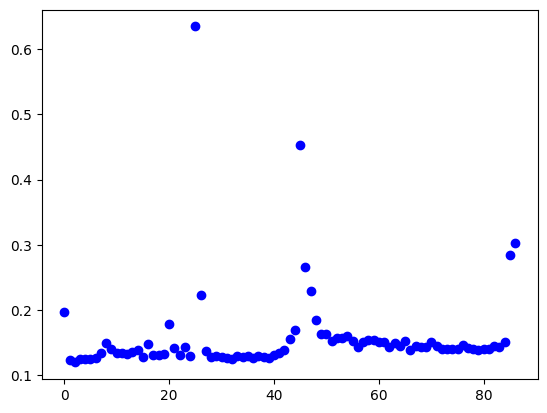

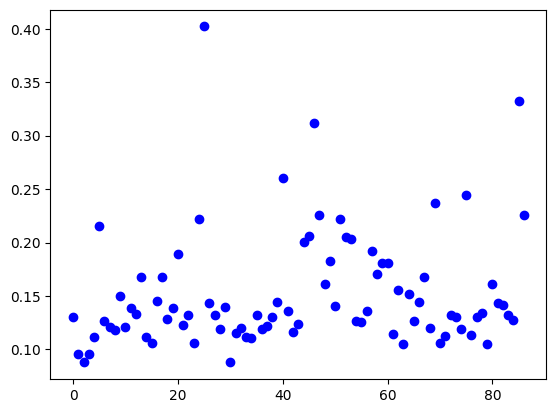

In [9]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=None,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

Save Model Architecture

In [10]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

/usr/local/lib/python3.11/dist-packages/einops/packing.py:148: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  lengths_of_composed_axes: List[int] = [-1 if -1 in p_shape else prod(p_shape) for p_shape in packed_shapes]
/usr/local/lib/python3.11/dist-packages/einops/packing.py:150: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_unknown_composed_axes = sum(int(x == -1) for x in lengths_of_composed_axes)
/usr/local/lib/python3.11/dist-packages/a_unet/apex.py:276: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. 

AssertionError: Required context `channels` at depth 4 in forward to be tensor of shape torch.Size([16, 256, 8204]), found torch.Size([16, 256, 8205])

### Sample

In [9]:
samples = trainer.sample_AE(file[10], n_steps=100)
print(samples[0].shape)

(1, 131072)


Save Samples

In [10]:
save_audio_file(samples[0, 0], path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result1.wav"), remote_kernel), 32000)

2025-06-04 06:41:43,593 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-04 06:41:43,607 - LIGHT_DEBUG - Saved file to:Results/model_result1.wav
